In [1]:
import numpy as np
import random
import torch as T
import torch.nn as nn
import torch.nn.functional as TNF
import pyro as P
import pyro.contrib.examples.polyphonic_data_loader as poly
import pyro.distributions as PD
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from matplotlib import pyplot as plt
from made import MADE


class simpleNNNormal(nn.Module):
    def __init__(self, input_size=1, hidden=16, out_size=1):
        super().__init__()
        self.hidden_layer = nn.Linear(input_size, hidden)
        self.loc_layer = nn.Linear(hidden, out_size)
        self.std_layer = nn.Linear(hidden, out_size)
        
    def forward(self, x_list):
        x = TNF.relu(self.hidden_layer(x_list))
        loc = self.loc_layer(x)
        std = self.std_layer(x)
        return loc, std

class simpleNNHidden(nn.Module):
    def __init__(self, input_size=1, hidden=16, out_size=1):
        super().__init__()
        self.hidden_layer = nn.Linear(input_size, hidden)
        self.out_layer = nn.Linear(hidden, out_size)

    def forward(self, x_list):
        x = TNF.relu(self.hidden_layer(x_list))
        return self.out_layer(x)

    
class EXP(nn.Module):
    def __init__(self):
        super().__init__()
        hid_size = 3

        self.nn_model_core_hidden = simpleNNHidden(out_size=hid_size)
        self.nn_q__i = simpleNNHidden(input_size=hid_size)
        self.nn_xp__i = simpleNNNormal(input_size=hid_size)
        self.nn_y2__i = simpleNNNormal(input_size=hid_size + 1)
        self.nn_y1__i =  simpleNNNormal(input_size=hid_size + 1)
        self.nn_core_hidden = simpleNNHidden(input_size=hid_size, out_size=hid_size)
        #self.nn_core_hidden = simpleNNHidden(input_size=hid_size + 1, out_size=hid_size)

    def core_guide(self, hidden, x, i=0):
        q__i_prob, = self.nn_q__i(hidden)
        q = P.sample(f'q_{i}', PD.Bernoulli(T.sigmoid(q__i_prob)))
        #cond = P.deterministic(f"cond_{i}", q < 0.5)
        #if cond:
        if q < 0.5:
            return x
        else:
            xp__i_mean, xp__i_std = self.nn_xp__i(hidden)
            xp = P.sample(f'xp_{i}', PD.Normal(xp__i_mean, TNF.softplus(xp__i_std)))
            y2__i_mean, y2__i_std = self.nn_y2__i(T.cat([hidden, T.tensor([xp])]))
            y2 = P.sample(f'y2_{i}', PD.Normal(y2__i_mean, TNF.softplus(y2__i_std)))
            y1__i_mean, y1__i_std = self.nn_y1__i(T.cat([hidden, T.tensor([y2])]))
            y1 = P.sample(f'y1_{i}', PD.Normal(y1__i_mean, TNF.softplus(y1__i_std)))
            return self.core_guide(self.nn_core_hidden(hidden), xp, i + 1) # maybe nn_core_hidden should take x
            #return self.core_guide(self.nn_core_hidden(T.cat([hidden, T.tensor([q__i_prob])])), xp, i + 1)

    def guide(self, obs):
        P.module("model", self)
        r = self.core_guide(self.nn_model_core_hidden(T.tensor([obs])), 0.0, i=0)

    def core_model(self, x, i=0):
        q = P. sample (f"q_{i}", PD. Bernoulli (T. tensor (0.5)))
        if q < 0.5:
            return x
        else :
            y1 = P. sample (f'y1_{i}', PD.Normal(x, 0.1))
            y2 = P. sample (f'y2_{i}', PD.Normal(y1 , 0.1))
            xp = P. sample (f'xp_{i}', PD.Normal(y2 , 0.1))
            return self.core_model(xp , i+1) + x

    def model(self, obs):
        P.module("model", self)
        r = self.core_model(0.0,i=0)
        return P.sample("r", PD.Normal(r ,0.01) , obs=obs)



[Step 10/200] Immediate Loss: 912.8664436206225 Accumlated Loss: 1248.8275929136876
[Step 20/200] Immediate Loss: 684.8133059409264 Accumlated Loss: 825.3153796929569
[Step 30/200] Immediate Loss: 757.2812944097818 Accumlated Loss: 675.0120173917113
[Step 40/200] Immediate Loss: 122.32561941180379 Accumlated Loss: 344.88789974487935
[Step 50/200] Immediate Loss: 46.93892909583635 Accumlated Loss: 82.36733579294105
[Step 60/200] Immediate Loss: 7.705004267951011 Accumlated Loss: 28.414723916228162
[Step 70/200] Immediate Loss: 5.748547925360034 Accumlated Loss: 13.245006939409766
[Step 80/200] Immediate Loss: 151.8044216160802 Accumlated Loss: 21.639094371502868
[Step 90/200] Immediate Loss: 4.824128819191391 Accumlated Loss: 7.721562867428018
[Step 100/200] Immediate Loss: 4.404667833588827 Accumlated Loss: 7.871801363228229
[Step 110/200] Immediate Loss: 5.595122290965392 Accumlated Loss: 11.833987938900867
[Step 120/200] Immediate Loss: 4.123647251018119 Accumlated Loss: 4.5078299547

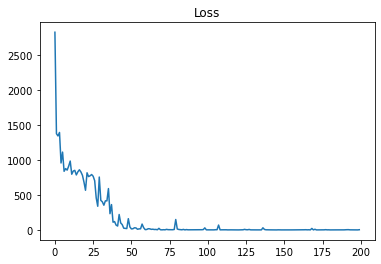

In [2]:

# Just for data generation
def core_model(x, i=0):
    q = P.sample(f"q_{i}", PD. Bernoulli (T. tensor (0.5)))
    if q < 0.5:
        return x
    else :
        y1 = P. sample (f'y1_{i}', PD.Normal(x, 0.1))
        y2 = P. sample (f'y2_{i}', PD.Normal(y1 , 0.1))
        xp = P. sample (f'xp_{i}', PD.Normal(y2 , 0.1))
        return core_model(xp , i+1) + x

def model(obs):
    r = core_model(0.0,i=0)
    return P.sample("r", PD.Normal(r ,0.01) , obs=obs)
    
def gen_data(n=100):
    d = []
    for _ in range(n):
        d.append(model(obs=None))
    return d

exp = EXP()
data = gen_data()
P.clear_param_store()
num_data = len(data)
adam_params = {"lr": 0.001, "betas": (0.95, 0.999)}
optimizer = Adam(adam_params)

svi = SVI(exp.model, exp.guide, optimizer, loss=Trace_ELBO())

n_steps = 200
log_interval = 10
# do gradient steps
loss = 0
loss_track = []
for step in range(1, n_steps + 1):
    imme_loss = 0
    for obs in data:
        imme_loss += svi.step(obs) / num_data
    loss_track.append(imme_loss)
    loss += imme_loss / log_interval
    
    if step % log_interval == 0:
        print("[Step {}/{}] Immediate Loss: {} Accumlated Loss: {}".format(step, n_steps, imme_loss, loss))
        loss = 0
plt.plot(loss_track)
plt.title("Loss")
plt.show()